The first thing we need to do is import the necessary libraries.

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Then we load the data and do some basic exploration 

Train Shape: (595212, 59)
Test Shape: (892816, 58)
Train Data:
    id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ...  \
0              0              0              1              0  ...   
1              0              0              0              1  ...   
2              0              0              0              1  ...   
3              0              1              0              0  ...   
4              0              1              0              0  ...   

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           9           1      

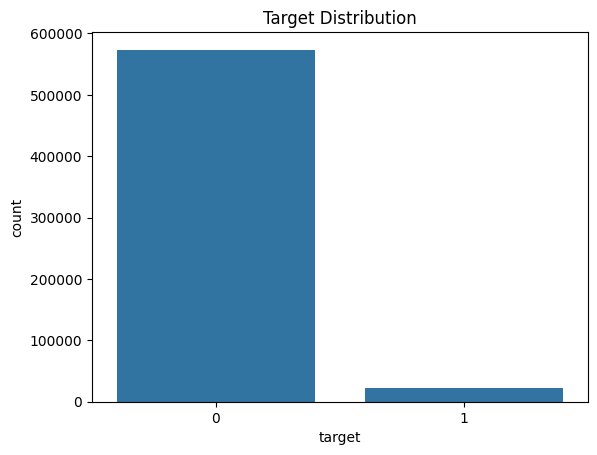

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Check data structure
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

#look at the first couple lines of data in the structures
print("Train Data:\n", train.head())
print("Test Data:\n", test.head())

#Description of test and train data
print("Train Data Description:\n", train.describe())
print("Test Data Description:\n", test.describe())

# Count missing values (-1) in each column
missing_values = (train == -1).sum()

print("\nMissing Values in Train Data:")
print(missing_values[missing_values > 0].sort_values(ascending=False))

# Check target distribution (imbalance)
sns.countplot(x=train["target"])
plt.title("Target Distribution")
plt.show()

This data is a little hard to do in depth analysis on becuase the data provider has already normalized and changed a bunch of the values for us. This means that all the data is already represented as a number so we don't have to deal with strings or categorical data. Although from the kaggle description we do know some of what the data represents. For example the data that ends in cat is categorical data, bin represents binary data, and features without without either of those are either continuous or ordinal.

We also can see that the data very heavily favors 0 in the target meaning that our models will probably want to favor 0 as the prediction unless we make an effort to change that.

In [10]:
#Preprocess the data
# Assuming the target column is named 'target' and features are in other columns
X_train = train.drop(columns=['target']).values
y_train = train['target'].values

X_test = test.drop(columns=['target']).values if 'target' in test else test.values
y_test = test['target'].values if 'target' in test else None

# Normalize features
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
if X_test is not None:
    X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)


We did the following to remove any missing data to give us a full data set to use. We replaced missing values with the median values for the feature. We also did some basic feature processing on the data.

Here are the functions for a basic regression model we are going to run on the data

In [11]:
#Logistic Regression model(without regularization)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, weights):
    m = len(y)
    predictions = sigmoid(np.dot(X, weights))
    cost = -(1/m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return cost

def gradient_descent(X, y, weights, learning_rate, iterations):
    m = len(y)
    for i in range(iterations):
        predictions = sigmoid(np.dot(X, weights))
        gradient = np.dot(X.T, (predictions - y)) / m
        weights -= learning_rate * gradient
        if i % 100 == 0:
            print(f"Iteration {i}: Cost {compute_cost(X, y, weights)}")
    return weights


Now we train the basic regression model

In [12]:
# Add a bias term to the features
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
weights = np.zeros(X_train.shape[1])

# Hyperparameters
learning_rate = 0.01
iterations = 1000

# Train the model
weights = gradient_descent(X_train, y_train, weights, learning_rate, iterations)

Iteration 0: Cost 0.6909939339984333
Iteration 100: Cost 0.5219232594570349
Iteration 200: Cost 0.41733747940939536
Iteration 300: Cost 0.3499475526044885
Iteration 400: Cost 0.3045705124876016
Iteration 500: Cost 0.2727598500850446
Iteration 600: Cost 0.24967118426110543
Iteration 700: Cost 0.232413589440209
Iteration 800: Cost 0.21919137245317347
Iteration 900: Cost 0.20884692215052367


Now , let's evaluate the model on the test set and create a submission for it:

In [13]:
if y_test is None:  # Assuming test data does not have target labels
    # Ensure the test dataset has an ID column
    if 'id' in test.columns:
        ids = test['id'].values
    else:
        raise ValueError("The test dataset must contain an 'ID' column for submission.")

    # Add a bias term to the test features
    X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

    # Calculate probabilities using the sigmoid function
    probabilities = sigmoid(np.dot(X_test, weights))

    # Create a DataFrame for submission
    submission = pd.DataFrame({
        'id': ids,
        'target': probabilities
    })

    # Save the submission file
    submission.to_csv('submission.csv', index=False)
    print("Submission file 'submission.csv' created successfully.")
else:
    print("Test dataset contains target labels. No submission file created.")

Submission file 'submission.csv' created successfully.


This submission got a score of 0.2499 which is much better than our dummy submission which got a score of 0.004